In [1]:
import cv2
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from original.entity import params, JointType
from badminton_pose_detector import PoseDetector, draw_person_pose

/home/daichi/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from crop_players import select_region, crop_person, modify_bbox, get_unit_length

In [3]:
#load model
pose_detector = PoseDetector("posenet", "../models/coco_posenet.npz", device=0, precise=True)
print("load model done!")

Loading the model...
load model done!


## Previous_Frame と Current_Frame でヒストグラムを比較する(Player0)

In [4]:
frame_num = 7
imgs_dir = pd.read_csv('../../badminton_action_recognition_using_pose_estimation/datasets/match_6/yihan_feature_images.txt', sep=',', usecols=[1,2])
prev_frame = imgs_dir["Img_name"][frame_num-1]
cur_frame = imgs_dir["Img_name"][frame_num]

In [7]:
# find the point of changing camera shot
nums = imgs_dir['Img_name'].str.extract('(.+)_(.+)\.(.+)')[1]
exclude_index = []
for i, num in enumerate(nums):
    if num == list(nums)[-1]:
        break
    elif (int(nums[i+1]) - int(num)) > 2:
        print('t-1: {}, t: {}, t+1: {}'.format(nums[i-1], num, nums[i+1]))
        exclude_index.append(i)

t-1: 008643, t: 008644, t+1: 009222
t-1: 009355, t: 009356, t+1: 009805
t-1: 010024, t: 010025, t+1: 010404
t-1: 011261, t: 011262, t+1: 012312
t-1: 012769, t: 012770, t+1: 013458
t-1: 013649, t: 013650, t+1: 014225
t-1: 014592, t: 014593, t+1: 015267
t-1: 015388, t: 015389, t+1: 016004
t-1: 016182, t: 016183, t+1: 016605
t-1: 016808, t: 016809, t+1: 017296
t-1: 017651, t: 017652, t+1: 018424
t-1: 018813, t: 018814, t+1: 019499
t-1: 019617, t: 019618, t+1: 020024
t-1: 020498, t: 020499, t+1: 021346
t-1: 021439, t: 021440, t+1: 022061
t-1: 022459, t: 022460, t+1: 023204
t-1: 023536, t: 023537, t+1: 026514
t-1: 026769, t: 026770, t+1: 027217
t-1: 027894, t: 027895, t+1: 028570
t-1: 028687, t: 028688, t+1: 029084
t-1: 029224, t: 029225, t+1: 029825
t-1: 029985, t: 029986, t+1: 030435
t-1: 030558, t: 030559, t+1: 030938
t-1: 031410, t: 031411, t+1: 032006
t-1: 032329, t: 032330, t+1: 033195
t-1: 033314, t: 033315, t+1: 033712
t-1: 034016, t: 034017, t+1: 034382
t-1: 034755, t: 034756, t+1:

In [8]:
exclude_index

[484,
 619,
 840,
 1699,
 2158,
 2351,
 2720,
 2843,
 3023,
 3228,
 3585,
 3976,
 4096,
 4572,
 4667,
 5067,
 5401,
 5658,
 6337,
 6456,
 6598,
 6760,
 6885,
 7359,
 7684,
 7805,
 8111,
 8486,
 8759,
 9307,
 9450,
 9716,
 9809,
 9951,
 10045,
 10197,
 10306,
 10862,
 11084,
 11228,
 11398,
 11539,
 11673,
 12007,
 12768,
 12929,
 12992,
 13276,
 13765,
 13822,
 14037,
 14144,
 14439,
 14808,
 15643,
 15821,
 15946,
 16009,
 16252,
 16411,
 16674,
 16860,
 17083,
 17207,
 17560,
 17616]

In [350]:
DATASETS_DIR = '../../badminton_action_recognition_using_pose_estimation/datasets'
labels = pd.read_csv(DATASETS_DIR + '/match_number.txt')
num = 2
name = labels.dir_name[num-1]
previous_bbox = np.zeros(4)

pose_0 = []
pose_1 = []

for i, img_name in enumerate(imgs_dir["Img_name"]):
    img = cv2.imread(DATASETS_DIR + '/match_{0}/{1}/{2}'.format(num, name, img_name))
    img_copy = img.copy()
    play_region_img, mask = select_region(img_copy)
    multi_poses, scores = pose_detector(play_region_img)
    # もしposes配列に一つもなければスキップする
    if (len(multi_poses) <= 1):
        print('Skipped at {}'.format(img_name))
        continue
    # 全パーツの高さの最大座標でポーズをソートする ⇨ pose_num = 0:bottom, 1:top player
    max_pose = np.max(multi_poses[:], axis=1)
    ordered_poses = multi_poses[np.argsort(max_pose[:,1])[::-1]]


    # ポーズの重心から固定サイズのbboxを切り取る
    new_bbox_0 = get_fix_bbox(ordered_poses[0])
    new_bbox_1 = get_fix_bbox(ordered_poses[1])
    
    
    ##
    # ここで正しい位置のbboxを算出
    correct_bbox_0 = calculate_bbox(ordered_poses, previous_bbox_0, img_copy)
    correct_bbox_1 = calculate_bbox(ordered_poses, previous_bbox_1, img_copy)
    ##
    # Crop Image
    cropped_img_0 = pose_detector.crop_image(img, correct_bbox_0)
    cropped_img_1 = pose_detector.crop_image(img, correct_bbox_1)

    cv2.imwrite(DATASETS_DIR + '/match_{0}/0/{1}'.format(num, img_name), cropped_img_0)
    cv2.imwrite(DATASETS_DIR + '/match_{0}/1/{1}'.format(num, img_name), cropped_img_1)

    print(img_name)
    ## POSE FEATURE
    pose0 = multi_person_poses[0][:,:2].reshape((1,-1), order='F')
    pose1 = multi_person_poses[1][:,:2].reshape((1,-1), order='F')
    pose_0.append(pose0[0])
    pose_1.append(pose1[0])

    # Stop
    if img_name == 'img_007299.jpg':
        break   

res: [1.0, 0.48939675840812724, 0.38508873307164665, 0.23366066870162677, 0.24124574301951832, 0.062045052801608123, 0.06547190701526194]
Max Histgram Score 1.0 at 0
res: [0.48939675840812724, 1.0, 0.7995581778655065, 0.7624287321125554, 0.9459450567069945, 0.6880071182511698, 0.6126963157207369]
Max Histgram Score 1.0 at 1
img_007164.jpg
res: [1.0, 0.4952992008251595, 0.27457486610378506, 0.3882753004730596, 0.22018356670372102, 0.12103169940305822, 0.15706894412901928]
Max Histgram Score 1.0 at 0
res: [0.49026221148899873, 0.9999478737055724, 0.9566435068045587, 0.7901783340015683, 0.76273485957655, 0.7234361630663454, 0.9129937900292131]
Max Histgram Score 0.9999478737055724 at 1
img_007165.jpg
res: [0.999986842358845, 0.49296099194307824, 0.3843054182187631, 0.2300820115740535, 0.24082697895856328, 0.06630994319327609]
Max Histgram Score 0.999986842358845 at 0
res: [0.48775297858440136, 0.9999468832524596, 0.7902770458982439, 0.7637585705052002, 0.9463135764523057, 0.69457910134352

KeyboardInterrupt: 

In [4]:
def calculate_bbox(ordered_poses:list, previous_bbox:list, img_copy):
    # Crop Previous Image
    prev_cropped_img = pose_detector.crop_image(img_copy, previous_bbox)
    prev_hist = CalcHist(prev_cropped_img)
    
    # Compare Current Image's histgram
    pose_len = len(ordered_poses)
    res = []
    bbox = []
    for i in range(pose_len):
        new_bbox = get_fix_bbox(ordered_poses[i])
        cropped_img = pose_detector.crop_image(img_copy, new_bbox)
        hist = CalcHist(cropped_img)
        score = cv2.compareHist(prev_hist, hist, 0)
        res.append(score)
        bbox.append(new_bbox)
    print('res:', res)
    ### -------- histgramを比較 --------------
    index = np.argmax(res)
    max_score = res[index]
    print('Max Histgram Score {} at {}'.format(max_score, index))
    return get_fix_bbox(ordered_poses[index])

In [5]:
def CalcHist(cropped_img):
# Histgram
    color = ('b','g','r')
    Hist = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([cropped_img],[i],None,[256],[0,256])
        Hist.append(histr[:])
       
    return np.squeeze(Hist)

In [308]:
#load pose info
# poses = np.load('../../badminton_action_recognition_using_pose_estimation/datasets/match_3/PoseFeature_scrach_hidayat.pkl')

In [316]:
np.array(poses.nonzero()).shape

(2, 10146)

## check for each

In [12]:
frame_num = 125
imgs_dir = pd.read_csv('../../badminton_action_recognition_using_pose_estimation/datasets/match_6/yihan_feature_images.txt', sep=',', usecols=[1,2])
prev_frame = imgs_dir["Img_name"][frame_num-1]
cur_frame = imgs_dir["Img_name"][frame_num]

Frame: img_008284.jpg


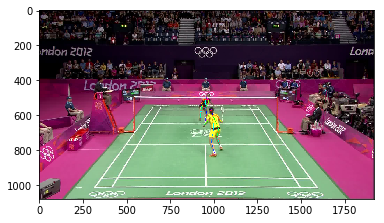

In [13]:
# === OpenCV ===
print('Frame:', prev_frame)
# Previous_Frame
prev_img = cv2.imread('../../badminton_action_recognition_using_pose_estimation/datasets/match_6/yihan/{}'.format(prev_frame))
#prev_img = cv2.imread('../data/youtube/img_08344.png')
prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2RGB)
prev_img_copy = prev_img.copy()
prev_play_region, prev_mask = select_region(prev_img_copy)
prev_multi_pose, prev_scores = pose_detector(prev_play_region)
prev_play_region = draw_person_pose(prev_img, prev_multi_pose)
plt.imshow(prev_play_region)

Frame: img_008285.jpg


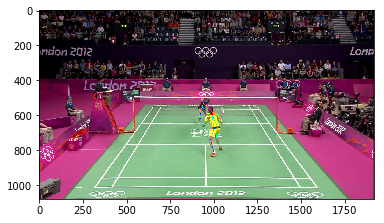

In [14]:
# === OpenCV ===
print('Frame:', cur_frame)
# Current_Frame
cur_img = cv2.imread('../../badminton_action_recognition_using_pose_estimation/datasets/match_6/yihan/{}'.format(cur_frame))
#cur_img = cv2.imread('../data/youtube/img_08346.png')
cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
cur_img_copy = cur_img.copy()
cur_play_region, cur_mask = select_region(cur_img_copy)
cur_multi_pose, cur_scores = pose_detector(cur_play_region)
cur_play_region = draw_person_pose(cur_img, cur_multi_pose)
plt.imshow(cur_play_region)

## Crop with fixed size of bbox

In [15]:
def get_fix_bbox(pose):
    # Pose Gravity
    pose_xy = pose[:, :2]
    nonzero = pose_xy.nonzero()
    current_bbox_center = pose_xy[nonzero].reshape(-1, 2).mean(axis=0)
    # Fixed Bbox
    height = 454
    width = 340
    new_bbox = np.zeros(4).astype(np.int64) # typeを指定しないとcrop_imageでslice errorが起きる
    new_bbox[0] = current_bbox_center[0] - (width // 2)
    new_bbox[1] = current_bbox_center[1] - (height // 2)
    new_bbox[2] = current_bbox_center[0] + (width // 2)
    new_bbox[3] = current_bbox_center[1] + (height // 2)
    return new_bbox

In [16]:
def PlotHist(cropped_img, title:str):
# Histgram
    color = ('b','g','r')
    Hist = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([cropped_img],[i],None,[256],[0,256])
        print('shape', histr.shape)
        Hist.append(histr[:])
        plt.plot(histr, color=col)
        plt.xlim([0,256])
    plt.title(title)
    plt.show()
    print('HIST', np.squeeze(Hist).shape)
    return np.squeeze(Hist), cropped_img

### Previous Frame

Pose Shape: (2, 18, 3)


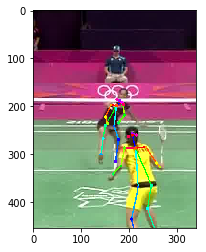

In [19]:
prev_max_pose = np.max(prev_multi_pose[:], axis=1)
prev_ordered_poses = prev_multi_pose[np.argsort(prev_max_pose[:,1])[::-1]]
print('Pose Shape:', prev_ordered_poses.shape)
# ポーズの重心から固定サイズのbboxを切り取る
# Fixed Bbox
prev_new_bbox_0 = get_fix_bbox(prev_ordered_poses[1])
# Crop Image
prev_cropped_img_0 = pose_detector.crop_image(prev_play_region, prev_new_bbox_0)
plt.imshow(prev_cropped_img_0)

shape (256, 1)
shape (256, 1)
shape (256, 1)


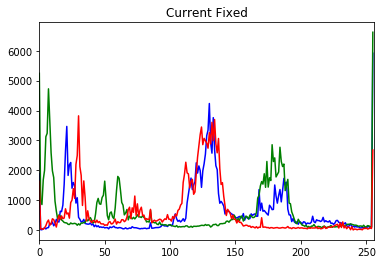

HIST (3, 256)


In [20]:
prev_hist, prev_cropped_img = PlotHist(prev_cropped_img_0, 'Current Fixed')

### Current Frame

Pose Shape: (5, 18, 3)


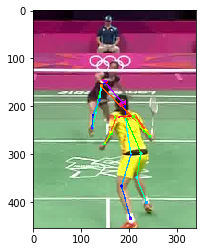

In [21]:
cur_max_pose = np.max(cur_multi_pose[:], axis=1)
cur_ordered_poses = cur_multi_pose[np.argsort(cur_max_pose[:,1])[::-1]]
print('Pose Shape:', cur_ordered_poses.shape)
# ポーズの重心から固定サイズのbboxを切り取る
# Fixed Bbox
new_bbox_0 = get_fix_bbox(cur_ordered_poses[1])
# Crop Image
cropped_img_0 = pose_detector.crop_image(cur_play_region, new_bbox_0)
plt.imshow(cropped_img_0)

Pose Shape: (2, 18, 3)


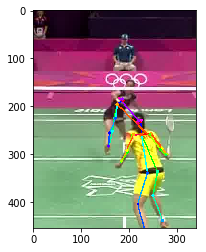

In [25]:
# 関節点が配列内で10より少なければドロップする
nonzero_list = [i for i, pose in enumerate(cur_multi_pose[:, :, 0]) if np.count_nonzero(pose) > 8]
cur_max_pose = np.max(cur_multi_pose[nonzero_list], axis=1)
cur_ordered_poses = cur_multi_pose[np.argsort(cur_max_pose[:,1])[::-1]]
print('Pose Shape:', cur_ordered_poses.shape)
# ポーズの重心から固定サイズのbboxを切り取る
# Fixed Bbox
new_bbox_0 = get_fix_bbox(cur_ordered_poses[1])
# Crop Image
cropped_img_0 = pose_detector.crop_image(cur_play_region, new_bbox_0)
plt.imshow(cropped_img_0)

In [26]:
cur_multi_pose

array([[[ 990.,  570.,    2.],
        [ 991.,  596.,    2.],
        [1011.,  594.,    2.],
        [1034.,  625.,    2.],
        [   0.,    0.,    0.],
        [ 971.,  597.,    2.],
        [ 962.,  632.,    2.],
        [ 948.,  653.,    2.],
        [1024.,  673.,    2.],
        [1015.,  723.,    2.],
        [1035.,  775.,    2.],
        [1003.,  676.,    2.],
        [ 983.,  741.,    2.],
        [1002.,  809.,    2.],
        [ 985.,  567.,    2.],
        [ 991.,  566.,    2.],
        [ 944.,  520.,    2.],
        [   0.,    0.,    0.]],

       [[ 952.,  525.,    2.],
        [ 941.,  532.,    2.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [ 934.,  562.,    2.],
        [ 930.,  589.,    2.],
        [ 923.,  620.,    2.],
        [ 937.,  562.,    2.],
        [ 924.,  593.,    2.],
        [ 922.,  620.,    2.],
      

shape (256, 1)
shape (256, 1)
shape (256, 1)


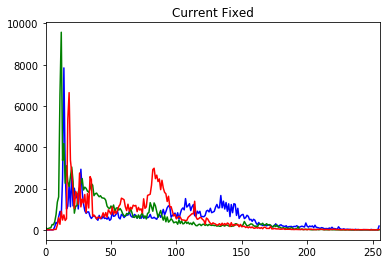

HIST (3, 256)


In [19]:
cur_hist, cur_cropped_img = PlotHist(cropped_img_0, 'Current Fixed')

### Compare Histgram

In [20]:
### -------- histgramを比較 --------------
ret = cv2.compareHist(cur_hist, prev_hist, 0)
print('Compared Histgram:', ret)

Compared Histgram: 0.30651718245503645


In [23]:
correct = calculate_bbox(cur_ordered_poses, prev_new_bbox_0, cur_img_copy)

res: [0.4465289336469537, 0.4256091525414848, 0.5596761567977648]
Max Histgram Score 0.5596761567977648 at 2


# Crop関数、切り出した画像のヒストグラムで類似度比較 Size Not Fixed

In [63]:
# ------------- Plot Histgram ---------------
def ChoosePlayer_PlotHist(multi_pose, pose_num:int, selected_img, title:str):
    max_pose = np.max(multi_pose[:], axis=1)
    ordered_poses = multi_pose[np.argsort(max_pose[:,1])[::-1]]
    print('Pose Shape:', ordered_poses.shape)
    unit, limb_length = get_unit_length(ordered_poses[pose_num])
    cropped_img, bbox = pose_detector.crop_person(np.array(selected_img), ordered_poses[pose_num], unit)
    # Histgram
    color = ('b','g','r')
    Hist = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([cropped_img],[i],None,[256],[0,256])
        print('shape', histr.shape)
        Hist.append(histr[:])
        plt.plot(histr, color=col)
        plt.xlim([0,256])
    plt.title(title)
    plt.show()
    print('HIST', np.squeeze(Hist).shape)
    return np.squeeze(Hist), cropped_img

Pose Shape: (4, 18, 3)
shape (256, 1)
shape (256, 1)
shape (256, 1)


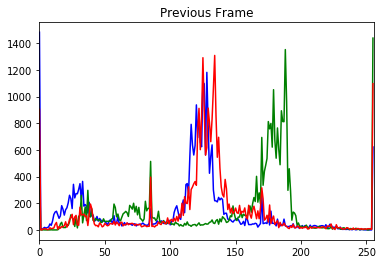

HIST (3, 256)


In [144]:
# Crop Previous Player
prev_hist, prev_cropped_img = ChoosePlayer_PlotHist(prev_multi_pose, 0, prev_play_region, 'Previous Frame')

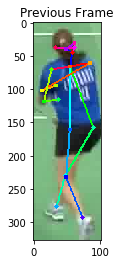

In [145]:
plt.title('Previous Frame')
plt.imshow(prev_cropped_img)

Pose Shape: (5, 18, 3)
shape (256, 1)
shape (256, 1)
shape (256, 1)


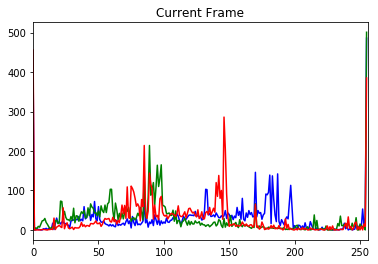

HIST (3, 256)


In [127]:
# Crop Current Player
cur_hist, cur_cropped_img = ChoosePlayer_PlotHist(cur_multi_pose, 3, cur_play_region, 'Current Frame')

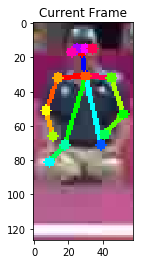

In [129]:
plt.title('Current Frame')
plt.imshow(cur_cropped_img)

In [143]:
### -------- histgramを比較 --------------
ret = cv2.compareHist(cur_hist, prev_hist, 0)
print('Compared Histgram:', ret)

Compared Histgram: 0.14757721444994


## PIL

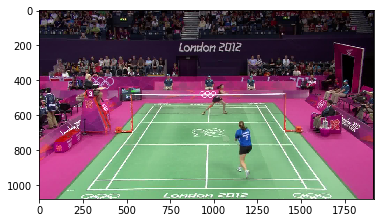

In [148]:
img = Image.open('../../badminton_action_recognition_using_pose_estimation/datasets/match_2/firdasari/{}'.format(prev_frame))
img_copy = np.array(img.copy())
play_region, mask = select_region(img_copy)
multi_pose, scores = pose_detector(play_region)
plt.imshow(img)

In [121]:
max_pose = np.max(multi_pose[:], axis=1)
multi_person_poses = multi_pose[np.argsort(max_pose[:,1])[::-1]]

In [122]:
multi_person_poses.shape

(4, 18, 3)

In [112]:
num = 1
unit, limb = get_unit_length(multi_person_poses[num])
crop_img, bbox = pose_detector.crop_person(np.array(img), multi_person_poses[num], unit)

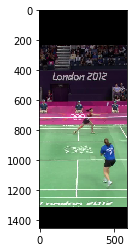

In [113]:
plt.imshow(crop_img)

Crop img shape: (315, 107, 3)


([array([  89.,  372.,  685.,  833.,  597.,  402.,  515.,  578.,  620.,
          499.,  790.,  876., 1048., 1137., 2603., 6788., 7876., 1977.,
          926.,  693.,  898.,  598.,  363.,  406.,  337.,  270.,  265.,
          217.,  238.,   63.,   65.,   81.]),
  array([3.000e+00, 1.680e+02, 7.580e+02, 6.860e+02, 7.510e+02, 7.450e+02,
         1.353e+03, 1.112e+03, 9.150e+02, 9.410e+02, 9.670e+02, 8.380e+02,
         7.450e+02, 6.680e+02, 7.770e+02, 8.110e+02, 8.000e+02, 8.300e+02,
         6.890e+02, 1.107e+03, 2.374e+03, 2.464e+03, 6.925e+03, 4.423e+03,
         5.780e+02, 1.670e+02, 1.510e+02, 2.030e+02, 1.180e+02, 1.730e+02,
         1.420e+02, 3.230e+02]),
  array([ 422., 1089., 2002., 1978., 1075.,  560.,  541.,  471.,  432.,
          367.,  464.,  621.,  530.,  963., 4238., 7976., 4965., 1467.,
          849.,  518.,  304.,  416.,  287.,  253.,  169.,  145.,  188.,
          199.,   70.,   62.,   27.,   57.])],
 array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,

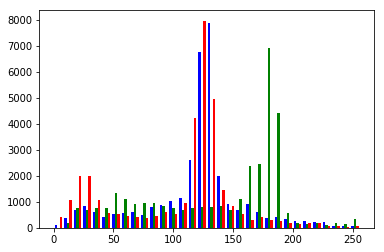

In [12]:
print('Crop img shape:', crop_img.shape)
b = crop_img[:,:,0].flatten()
g = crop_img[:,:,1].flatten()
r = crop_img[:,:,2].flatten()
bins_range = range(0,257, 8)

plt.hist((b,g,r),bins=bins_range, color=['b', 'g', 'r'])
#plt.imshow()

In [15]:
def plot_hist(multi_person_poses, i):
    unit, limb = get_unit_length(multi_person_poses[i])
    crop_img, bbox = pose_detector.crop_person(img, multi_person_poses[i], unit)
    b = crop_img[:,:,0].flatten()
    g = crop_img[:,:,1].flatten()
    r = crop_img[:,:,2].flatten()
    bins_range = range(0,257, 8)

    plt.hist((b,g,r),bins=bins_range, color=['b', 'g', 'r'])
    #plt.imshow()

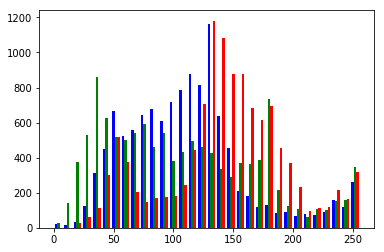

In [19]:
plot_hist(multi_person_poses, 1)

## calcHistとcompareHistを使ってヒストグラムの比較で検出精度を上げる

## プレー画面以外でエラーを起こすため、アノテーションされた時間内だけで選手を切り出す

In [25]:
original_anno = pd.read_csv('../../Annotations/fine_anno_txt/Baun-Augustyn-GrpG-LondonOlympics-2012.txt', sep=',', delimiter='\t', header=None, usecols=[2,3,5], names=["start", "end", "label"])
original_anno.tail()

,start,end,label
843,1791500,1792073,lbpt
844,1792073,1792473,rtpb
845,1792473,1792879,bhpb
846,1792879,1793714,rtpt
847,1793714,1795152,n


In [19]:
len(original_anno)

848

In [24]:
330800/25/60

220.53333333333333

In [53]:
import os
img_list = os.listdir('../data/0/')
img_lists = np.sort(img_list)
for i, img in enumerate(img_lists):
    print('{0}times, {1}'.format(i, img))

0times, .ipynb_checkpoints
1times, img_08290.png
2times, img_08291.png
3times, img_08292.png
4times, img_08293.png
5times, img_08294.png
6times, img_08295.png
7times, img_08296.png
8times, img_08297.png
9times, img_08298.png
10times, img_08299.png
11times, img_08300.png
12times, img_08301.png
13times, img_08302.png
14times, img_08303.png
15times, img_08304.png
16times, img_08305.png
17times, img_08306.png
18times, img_08307.png
19times, img_08308.png
20times, img_08309.png
21times, img_08310.png
22times, img_08311.png
23times, img_08312.png
24times, img_08313.png
25times, img_08314.png
26times, img_08315.png
27times, img_08316.png
28times, img_08317.png
29times, img_08318.png
30times, img_08319.png
31times, img_08320.png
32times, img_08321.png
33times, img_08322.png
34times, img_08323.png
35times, img_08324.png
36times, img_08325.png
37times, img_08326.png
38times, img_08327.png
39times, img_08328.png
40times, img_08329.png
41times, img_08330.png
42times, img_08331.png
43times, img_083

## 姿勢の並び替え
poseの配列をy座標で並び替えてbottom playerとtop playerで分割する

In [33]:
poses[:, 10, 1]

array([ 586.,  817.,  455.,  442.,    0.])

In [32]:
np.sort(poses[:, 10, 1])[::-1]

array([ 817.,  586.,  455.,  442.,    0.])

# Single image for test. 
## poses, score = pose_detector(img)

5


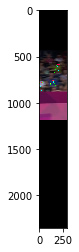

In [12]:
# read image
img = Image.open('../../Annotations/youtube/baun/img_08404.png')
img = np.array(img)
# select detection area
img, mask = select_region(img)
# inference
poses, scores = pose_detector(img) # posesはscoreが高い順
img = draw_person_pose(img, poses)

unit, limb_length = get_unit_length(poses[0])
cropped_img, bbox = crop_person(img, poses[0], unit)
print(len(poses))
# new_bbox = get_new_bbox(current_bbox_center, previous_bbox)
cropped_img = pose_detector.crop_image(img, bbox)
plt.imshow(cropped_img)

## 審判の顔を検出してしまっている..

## poses

25.7508565256


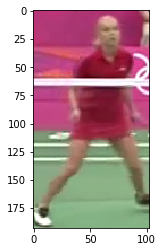

In [23]:
# detect bottom player(0:bottom, 1:top player)
unit_0, limbs_len = get_unit_length(poses[0])
print(unit_0)
cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img_b)

## poses, scores = pose_detector.detect_precise(img_pre)
## poses_pre

[[ 893.  436.    2.]
 [ 886.  457.    2.]
 [ 870.  458.    2.]
 [ 858.  480.    2.]
 [ 863.  498.    2.]
 [ 903.  455.    2.]
 [ 905.  481.    2.]
 [ 909.  499.    2.]
 [ 871.  508.    2.]
 [ 858.  551.    2.]
 [ 832.  586.    2.]
 [ 896.  508.    2.]
 [ 911.  544.    2.]
 [ 918.  576.    2.]
 [ 888.  433.    2.]
 [ 895.  432.    2.]
 [ 881.  436.    2.]
 [ 898.  435.    2.]]


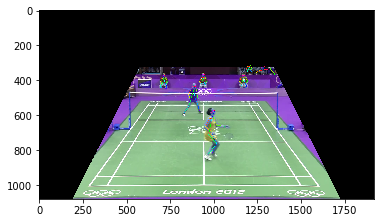

In [79]:
img_pre = cv2.imread('../data/youtube/img_08339.png')
img_pre, mask = select_region(img_pre)

# res_img = cv2.addWeighted(img, 0.6, draw_person_pose(img, poses), 0.4, 0)
# draw keypoint
poses_pre, scores = pose_detector.detect_precise(img_pre) # posesはscoreが高い順
img_pre = draw_person_pose(img_pre, poses_pre)

plt.imshow(img_pre)
print(poses_pre[0])

377.484268333
[   95.35197953    67.35725648    82.61961026    91.04943712    60.8276253
    59.94163828    12.04159458    51.88448708    48.27007354    36.40054945
    11.04536102    46.5188134     43.28972164  1175.02723373    45.69463864
     7.28010989     7.61577311    16.40121947  1152.53156139]


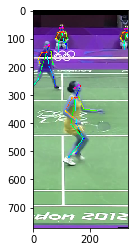

In [85]:
# detect bottom player(0:bottom, 1:top player)
unit_pre_0, limbs_len_pre = get_unit_length(poses_pre[1])
print(unit_pre_0)
print(limbs_len_pre)
cropped_img, bbox = crop_person(img_pre, poses_pre[1], unit_pre_0) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img)

# multi images

In [15]:
# read multi images
for i in range(0,61):    
    print('83{0:02d}'.format(i))
    # read image
    img = cv2.imread('../data/youtube/img_083{0:02d}.png'.format(i))
    # select detection area
    img, mask = select_region(img)
    # inference
    poses, scores = pose_detector(img) # posesはscoreが高い順
    # draw keypoint
    img = draw_person_pose(img, poses)
    # plt.imshow(img)
    
    # compare unit_length 
    unit_0 = get_unit_length(poses[0])
    unit_1 = get_unit_length(poses[1])
    print(unit_1)
    if (unit_1 > 100):
        print(i)
        break
    # detect bottom player(0:bottom, 1:top player)
    cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
    if cropped_img_b is not None:
        crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/0/crop_{:d}.png'.format(i), crop_img_b)

    # detect top player
    cropped_img, bbox = crop_person(img, poses[1], unit_1) 
    if cropped_img is not None:
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/1/crop_{:d}.png'.format(i), crop_img)

8300
23.1604041602
8301
22.8886976893
8302
22.7768242437
8303
23.3837262799
8304
23.0123025444
8305
23.8046210198
8306
23.8102025666
8307
24.1815382659
8308
23.3440314045
8309
23.6728515044
8310
23.9763472108
8311
24.8892989568
8312
24.5155856087
8313
24.0412436339
8314
24.1446919293
8315
23.448303899
8316
22.7705782326
8317
22.985473912
8318
22.2795599226
8319
23.0119738999
8320
22.9951745644
8321
23.410459384
8322
22.2508998772
8323
24.3489835384
8324
24.8253212601
8325
24.0743849765
8326
24.7657991346
8327
25.1410389542
8328
26.3954220573
8329
27.2214471172
8330
27.2774241212
8331
26.1193110958
8332
25.3058630592
8333
25.6212625673
8334
25.2575851421
8335
26.1699147211
8336
25.4435723141
8337
24.8241934983
8338
24.8139654057
8339
377.484268333


In [ ]:
if (unit_0 > unit_1): # (larger=bottom)
        # detect bottom player(0:bottom, 1:top player)
        cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
        if cropped_img_b is not None:
            crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)
        
        # detect top player
        cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
        if cropped_img is not None:
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)
    else:
        print('detect bottom player failed.')    


In [ ]:
# detect bottom player(0:bottom, 1:top player)
cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)

# detect top player
cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)